# PyCon 2022: Sentiment Analysis of Tweets

First, we will retrieve data on tweets about PyCon from the Cosmos database.

In [5]:
from azure.cosmos import CosmosClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# this sets up the Matplotlib interactive windows:
%matplotlib widget
plt.style.use("_mpl-gallery-nogrid")

# Initialize and create the Cosmos client
endpoint = "https://tweets-pycon.documents.azure.com:443/"
key = 'KEYHERE'

client = CosmosClient(endpoint, key)

# Retrieve database and container
database = client.get_database_client('tweetsdatabase')
container = database.get_container_client('tweetscollection')

### Overview
A summary of the distribution of tweets.

So far, there have been 624 tweets made about PyCon, Azure and Python!

The 624 tweets have been classified as follows:


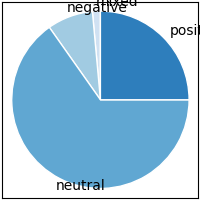

In [6]:
tweets_query = """SELECT tweets.sentiment 
                  FROM tweetscollectionm tweets"""

tweets = list(
    container.query_items(query=tweets_query, enable_cross_partition_query=True)
)

print(
    "So far, there have been {0} tweets made about PyCon, Azure and Python!\n".format(
        len(tweets)
    )
)
print("The {0} tweets have been classified as follows:".format(len(tweets)))

df = pd.DataFrame(tweets, columns=["sentiment"])
df = df.groupby("sentiment")["sentiment"].agg(["count"])  #  Aggregate data

# plot
colors = plt.get_cmap("Blues")(np.linspace(0.2, 0.7, len(list(df.index))))
fig, ax = plt.subplots()
ax.pie(
    df["count"],
    colors=colors,
    radius=3,
    center=(4, 4),
    wedgeprops={"linewidth": 1, "edgecolor": "white"},
    labels=list(df.index),
    frame=True,
    startangle=90,
)

plt.show()

### Positive Tweets

In [7]:
# Extreme positive tweets, confidence score for positive > 0.98
tweets_pos_query = """SELECT {"tweet":tweets.text} 
                      AS tweet_info 
                      FROM tweetscollection tweets 
                      WHERE tweets.confidence_scores.positive > 0.98 
                      OFFSET 0 LIMIT 10"""

tweets_positive = list(
    container.query_items(query=tweets_pos_query, enable_cross_partition_query=True)
)

tweets_pos_display = pd.json_normalize(tweets_positive, max_level=1)

print("Some very high positive confidence (confidence score is > 0.98) score tweets")
print(tweets_pos_display)

Some very high positive confidence (confidence score is > 0.98) score tweets
                                    tweet_info.tweet
0  RT @Yhg1s: I'm at the Salt Palace convention c...
1  RT @adem_onar: Best #MachineLearning #Algorith...
2  Best #MachineLearning #Algorithms for classifi...
3  RT @adem_onar: Best #MachineLearning #Algorith...
4  RT @adem_onar: Best #MachineLearning #Algorith...
5  RT @adem_onar: Best #MachineLearning #Algorith...
6  RT @falconcode16: Best open-source app framewo...
7  RT @adem_onar: Best #MachineLearning #Algorith...
8  RT @fikinft: Some great @apocalypticapes backg...
9  @pystar @reuvenmlerner @pycon If you write abo...


### Negative Tweets

In [8]:
# Extreme negative tweets, confidence score for negative > 0.98
tweets_neg_query = """SELECT {"tweet":tweets.text} 
                      AS tweet_info 
                      FROM tweetscollection tweets 
                      WHERE tweets.confidence_scores.negative > 0.98
                      OFFSET 0 LIMIT 10"""

tweets_negative = list(
    container.query_items(query=tweets_neg_query, enable_cross_partition_query=True)
)

tweets_neg_display = pd.json_normalize(tweets_negative, max_level=1)

print("Some very high negative confidence (confidence score is > 0.98) score tweets")
print(tweets_neg_display)


Some very high negative confidence (confidence score is > 0.98) score tweets
                                    tweet_info.tweet
0  RT @energydata123: Day 87, 88:\nCame across an...
1  RT @energydata123: Day 87, 88:\nCame across an...
2  @MrEinFan Im still mostly using sorcery, need ...
3  @CircuitPython @pycon Looks like I made it int...
4  @muheuenga @juanluisback I was never involved ...


### Neutral Tweets

In [9]:
# Extreme neutral tweets, confidence score for neutral > 0.98
tweets_neutral_query = """SELECT {"tweet":tweets.text} 
                          AS tweet_info 
                          FROM tweetscollection tweets 
                          WHERE tweets.confidence_scores.neutral > 0.98
                          OFFSET 0 LIMIT 10"""

tweets_neutral = list(
    container.query_items(query=tweets_neutral_query, enable_cross_partition_query=True)
)

tweets_neutral_display = pd.json_normalize(tweets_neutral, max_level=1)

print("Some very high neutral confidence (confidence score is > 0.98) score tweets")
print(tweets_neutral_display)


Some very high neutral confidence (confidence score is > 0.98) score tweets
                                    tweet_info.tweet
0  Target is looking for a Sr. Data Scientist - O...
1  Az.Cdn v2.0.0-preview https://t.co/I6kvJXzPO3 ...
2  Target is looking for a Sr. Data Scientist - O...
3  Azure Cosmos DB Cassandra API: A true differen...
4  Lumen is looking for a SR MGR DATA SCIENCE\nht...
5  History of #machinelearning &amp; #DataScience...
6  Microsoft Azure Data Scientist Associate - DP-...
7  Global Shutter Camera Module\n#Robotics #AI #I...
8  Global Shutter Camera Module\n#Robotics #AI #I...
9  #youtube Belajar Linear Programming Python Goo...


### Mixed Tweets

In [10]:
tweets_query = (
    "SELECT tweets.text FROM tweetscollectionm tweets WHERE tweets.sentiment = 'mixed' OFFSET 0 LIMIT 10"
)

tweets_mixed = list(
    container.query_items(query=tweets_query, enable_cross_partition_query=True)
)

df_mixed_tweets = pd.DataFrame(tweets_mixed, columns=["text"])

print(
    "Following are {0} tweets that do not have a high confidence score in any one sentiment, and are therefore cateforized as 'mixed'.".format(
        len(tweets_mixed)
    )
)

print(df_mixed_tweets)


Following are 9 tweets that do not have a high confidence score in any one sentiment, and are therefore cateforized as 'mixed'.
                                                text
0  @SamHLevey R is great for what it is, a better...
1  Here's the weather forecast for Salt Lake City...
2  RT @rootsecdev: Found this cool little script ...
3  @AkitaOnRails Muuuito legal isso. Ganhou uma e...
4  RT @Tofag_E: Wrote an API call program, I've s...
5  @hmmmmmbbb @pycon It's like a foreign language...
6  @s_gruppetta_ct @pystar @pycon Oh, right — I s...
7  @brandon_rhodes @pycon Enjoy! Just got over CO...
8  Stressing about a python exam this weekend.  J...


### Overall Analysis

In [11]:
total_tweets = [pos_count, neg_count, neutral_count, mixed_count]

max_value = max(total_tweets)

overall_sentiment = None

if total_tweets.index(max_value) == 0:
    overall_sentiment = "positive"
elif total_tweets.index(max_value) == 1:
    overall_sentiment = "negative"
elif total_tweets.index(max_value) == 2:
    overall_sentiment = "neutral"
elif total_tweets.index(max_value) == 3:
    overall_sentiment = "mixed"

print(
    "From the sentiment analysis, we have detected that so far, the overall sentiment of tweets at PyCon 2022 is",
    overall_sentiment,
    ".",
)


NameError: name 'pos_count' is not defined